In [ ]:
from pasteur.kedro.ipython import *
register_kedro()

INFO     Kedro project Pasteur                                                                                           __init__.py:77
INFO     Defined global variable 'context', 'session', 'catalog' and 'pipelines'                                         __init__.py:78
INFO     Registered line magic 'run_viz'                                                                                 __init__.py:84
INFO     Registered line magic 'reload_kedro_mlflow'                                                                     __init__.py:84


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
[a for a in catalog.list() if "mimic_tab" in a and "params:" not in a and "trn" in a]

['mimic_tab_admissions.trn.ids_table', 'mimic_tab_admissions.trn.table']


In [ ]:
from pasteur.metadata import Metadata

trn: pd.DataFrame = catalog.load("mimic_tab_admissions.trn.table")
table = catalog.load("mimic_tab_admissions.wrk.idx_table")

In [ ]:
table.head()

,dod_year,dod_week,dod_day,admittime_year,admittime_week,admittime_day,admittime_time,dischtime_day,dischtime_time,deathtime_day,deathtime_time,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,hospital_expire_flag,gender
hadm_id,,,,,,,,,,,,,,,,,,,,
21038362,0,0,0,0,38,5,14,7,11,0,0,3,0,7,2,1,3,6,0,0
24941086,0,0,0,0,39,3,23,8,11,0,0,3,0,7,2,1,0,7,0,0
21965160,0,0,0,0,1,5,9,8,14,0,0,3,0,7,2,1,0,6,0,1
24709883,0,0,0,0,51,4,17,8,21,0,0,3,0,7,2,1,0,4,0,0
23272159,0,0,0,0,34,4,8,6,12,0,0,3,0,7,2,1,0,2,0,1


In [ ]:
attrs = trn["idx"].get_attributes()

In [ ]:
from pasteur.transform.attribute import Level

head: Level = attrs["dod"]["dod_year"].head
head

{'None', ['1.546875', '4.640625', '7.734375', '10.828125', '13.921875', '17.015625', '20.109375', '23.203125', '26.296875', '29.390625', '32.484375', '35.578125', '38.671875', '41.765625', '44.859375', '47.953125', '51.046875', '54.140625', '57.234375', '60.328125', '63.421875', '66.515625', '69.609375', '72.703125', '75.796875', '78.890625', '81.984375', '85.078125', '88.171875', '91.265625', '94.359375', '97.453125']}


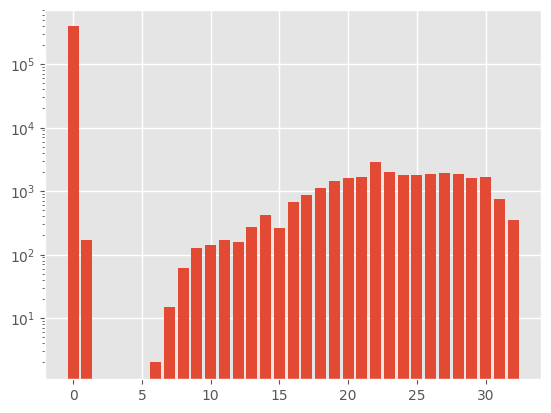

In [ ]:
import numpy as np

counts = np.bincount(table["dod_year"])

import matplotlib.pyplot as plt
plt.style.use("./utils/light.mplstyle")
plt.bar(range(len(counts)), counts)
plt.yscale("log")

In [ ]:
# Create group tree for attribute
n = head.get_domain(0)
group_for_x = lambda x: tuple(i == x for i in range(n))

def merge_groups(a, b):
    return tuple(i or j for i, j in zip(a, b))

class OrdNode(list):
    pass

class CatNode(list):
    pass

def create_tree(node: Level, ofs: int = 0) -> list:
    out = CatNode() if node.type == "cat" else OrdNode()

    for child in node:
        if isinstance(child, Level):
            out.append(create_tree(child, ofs))
        else:
            out.append(group_for_x(ofs))
    
        ofs += 1
    
    return out

In [ ]:
group_sizes = {}
def get_group_size(g: tuple):
    if g in group_sizes:
        return group_sizes[g]

    s = 0
    for i, present in enumerate(g):
        if present:
            s += counts[i]
    
    group_sizes[g] = s
    return s

def print_group(g: tuple):
    s = "("
    for i, present in enumerate(g):
        if present:
            s += f"{i},"
    return s[:-1] + "):" + str(get_group_size(g))

def print_tree(node: list):
    s = "[" if isinstance(node, OrdNode) else "{"
    for n in node:
        if isinstance(n, list):
            s += print_tree(n)
        else:
            s += print_group(n)
        s += ","
    s = s[:-1] + ("]" if isinstance(node, OrdNode) else "}")
    return s

print(print_tree(create_tree(head)))

{(0):391174,[(1):172,(2):0,(3):0,(4):0,(5):0,(6):2,(7):15,(8):61,(9):129,(10):141,(11):168,(12):158,(13):271,(14):425,(15):263,(16):668,(17):865,(18):1100,(19):1439,(20):1592,(21):1657,(22):2860,(23):2003,(24):1777,(25):1823,(26):1844,(27):1936,(28):1856,(29):1628,(30):1671,(31):748,(32):351]}


In [ ]:
from itertools import combinations

group_sizes = {}
tree = create_tree(head)

def merge_groups_in_node(node: list, a: tuple, b: tuple):
    tmp_node = node.copy()
    node.clear()

    for child in tmp_node:
        if child == a:
            node.append(merge_groups(a, b))
        elif child == b:
            pass
        else:
            node.append(child)

def prune_tree(tree: list):
    for i, child in enumerate(tree):
        if not isinstance(child, list):
            continue

        if len(child) == 1:
            tree[i] = child[0]
        else:
            prune_tree(child)

def find_smallest_group(parent: list):
    s_node = None
    s_a = None
    s_b = None
    s_size = -1

    # First do a recursive pass
    for child in parent:
        if isinstance(child, list):
            node, a, b, size = find_smallest_group(child)
            if s_size == -1 or size < s_size:
                s_node = node
                s_a = a
                s_b = b
                s_size = size

    # Secondly, consider children
    if isinstance(parent, OrdNode):
        # For ordinal nodes we only check nearby nodes
        for i in range(len(parent) - 1):
            a = parent[i]
            if isinstance(a, list):
                continue
            b = parent[i + 1]
            if isinstance(b, list):
                continue

            size = get_group_size(merge_groups(a, b))
            if s_size == -1 or size < s_size:
                s_node = parent
                s_a = a
                s_b = b
                s_size = size
    else:
        # For categorical nodes we check all pairs
        for i, j in combinations(range(len(parent)), 2):
            a = parent[i]
            if isinstance(a, list):
                continue
            b = parent[j]
            if isinstance(b, list):
                continue

            size = get_group_size(merge_groups(a, b))
            if s_size == -1 or size < s_size:
                s_node = parent
                s_a = a
                s_b = b
                s_size = size

    return s_node, s_a, s_b, s_size

print(f"Init: {print_tree(tree)}")
for i in range(1, n):

    node, a, b, _ = find_smallest_group(tree)
    merge_groups_in_node(node, a, b)
    prune_tree(tree)
    print(f"{i:4d}: {print_tree(tree)}")


Init: {(0):391174,[(1):172,(2):0,(3):0,(4):0,(5):0,(6):2,(7):15,(8):61,(9):129,(10):141,(11):168,(12):158,(13):271,(14):425,(15):263,(16):668,(17):865,(18):1100,(19):1439,(20):1592,(21):1657,(22):2860,(23):2003,(24):1777,(25):1823,(26):1844,(27):1936,(28):1856,(29):1628,(30):1671,(31):748,(32):351]}
   1: {(0):391174,[(1):172,(2,3):0,(4):0,(5):0,(6):2,(7):15,(8):61,(9):129,(10):141,(11):168,(12):158,(13):271,(14):425,(15):263,(16):668,(17):865,(18):1100,(19):1439,(20):1592,(21):1657,(22):2860,(23):2003,(24):1777,(25):1823,(26):1844,(27):1936,(28):1856,(29):1628,(30):1671,(31):748,(32):351]}
   2: {(0):391174,[(1):172,(2,3,4):0,(5):0,(6):2,(7):15,(8):61,(9):129,(10):141,(11):168,(12):158,(13):271,(14):425,(15):263,(16):668,(17):865,(18):1100,(19):1439,(20):1592,(21):1657,(22):2860,(23):2003,(24):1777,(25):1823,(26):1844,(27):1936,(28):1856,(29):1628,(30):1671,(31):748,(32):351]}
   3: {(0):391174,[(1):172,(2,3,4,5):0,(6):2,(7):15,(8):61,(9):129,(10):141,(11):168,(12):158,(13):271,(14):4